In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets

In [2]:
import codecs

In [3]:
download =  datasets.MNIST('./MNIST/', train=True, download=True)

In [4]:
Datapath = '/home/abhishek/MNIST/MNIST/raw'

In [5]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [6]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [7]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [8]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [9]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [10]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [11]:
use_gpu = torch.cuda.is_available()

In [12]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            #nn.Linear(100, 50),
            nn.ReLU())
        self.decoder = nn.Sequential(
            #nn.Linear(50, 100),
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)
print(init_weights[0].numpy().shape)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)
(784,)


In [13]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.7, momentum=0.9)

In [14]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss#.data[0]
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.075734
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.047527
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.034247
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.028292
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.024703
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.022378
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.020635
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.019112
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.017892
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.017081
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.016426
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.015778
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.015051
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.014598
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.014200
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.013859
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.013503
At Iteration : 18 / 30  ;  Mean-Squared 

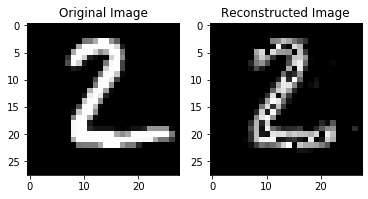

In [15]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
if use_gpu:
    outputImg = net(Variable((TestImg.double().cuda())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28).cpu()
else:
    outputImg = net(Variable((TestImg.double())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28)

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

In [16]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
print(trained_weights[0].numpy().shape)

(784,)


In [17]:
trained_weights

tensor([[-0.0287, -0.0154, -0.0237,  ..., -0.0247, -0.0118,  0.0098],
        [-0.0161,  0.0219,  0.0093,  ...,  0.0271,  0.0207, -0.0271],
        [-0.0314, -0.0210,  0.0176,  ..., -0.0118,  0.0106, -0.0299],
        ...,
        [ 0.0021,  0.0161, -0.0020,  ..., -0.0019,  0.0254, -0.0125],
        [ 0.0078, -0.0309, -0.0068,  ..., -0.0321, -0.0040,  0.0244],
        [ 0.0201,  0.0117, -0.0224,  ...,  0.0325,  0.0353, -0.0296]],
       dtype=torch.float64)

In [18]:
(1 + trained_weights)*127.5

tensor([[123.8386, 125.5322, 124.4723,  ..., 124.3567, 125.9893, 128.7457],
        [125.4523, 130.2932, 128.6855,  ..., 130.9601, 130.1338, 124.0436],
        [123.4997, 124.8254, 129.7472,  ..., 126.0003, 128.8521, 123.6918],
        ...,
        [127.7695, 129.5468, 127.2435,  ..., 127.2636, 130.7379, 125.9117],
        [128.4904, 123.5594, 126.6344,  ..., 123.4017, 126.9902, 130.6114],
        [130.0581, 128.9888, 124.6421,  ..., 131.6465, 132.0062, 123.7286]],
       dtype=torch.float64)

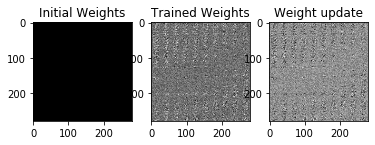

In [19]:
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(-1,280,280).byte().cpu()
    trained_weights = trained_weights.view(-1,280,280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1,280,280).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()


In [20]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [21]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [22]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss#.data[0]
    inputs = TestImages.double()/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.size()[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

/home/abhishek/anaconda3/envs/fast/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration: 1 / 30  ;  Training Loss: 1.307882 ; Testing Acc: 84.000000 
At Iteration: 2 / 30  ;  Training Loss: 0.524084 ; Testing Acc: 88.000000 
At Iteration: 3 / 30  ;  Training Loss: 0.427900 ; Testing Acc: 89.000000 
At Iteration: 4 / 30  ;  Training Loss: 0.388311 ; Testing Acc: 90.000000 
At Iteration: 5 / 30  ;  Training Loss: 0.365396 ; Testing Acc: 90.000000 
At Iteration: 6 / 30  ;  Training Loss: 0.349987 ; Testing Acc: 90.000000 
At Iteration: 7 / 30  ;  Training Loss: 0.338599 ; Testing Acc: 90.000000 
At Iteration: 8 / 30  ;  Training Loss: 0.329627 ; Testing Acc: 91.000000 
At Iteration: 9 / 30  ;  Training Loss: 0.322209 ; Testing Acc: 91.000000 
At Iteration: 10 / 30  ;  Training Loss: 0.315830 ; Testing Acc: 91.000000 
At Iteration: 11 / 30  ;  Training Loss: 0.310181 ; Testing Acc: 91.000000 
At Iteration: 12 / 30  ;  Training Loss: 0.305046 ; Testing Acc: 91.000000 
At Iteration: 13 / 30  ;  Training Loss: 0.300272 ; Testing Acc: 91.000000 
At Iteration: 14 / 30

In [23]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

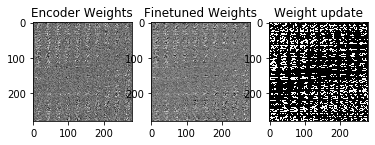

In [24]:
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,280,280).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,280,280).byte()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

In [25]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

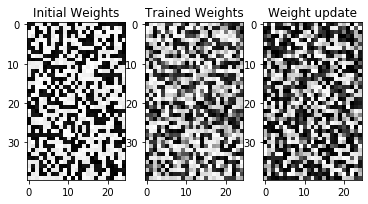

In [26]:
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

In [28]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        
#visualize weights for alexnet - first conv layer
plot_weights(net, 0, single_channel = True)

Can only visualize layers which are convolutional
